In [1]:
!python -V

Python 3.9.15


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error

In [7]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

2022/12/30 13:43:12 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2022/12/30 13:43:12 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

<Experiment: artifact_location='./mlruns/1', creation_time=1672407793556, experiment_id='1', last_update_time=1672407793556, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [8]:
 df = pd.read_parquet('../../data/green_tripdata_2021-01.parquet')

In [9]:
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,0.5,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,0.5,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,0.5,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,0.5,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,0.0,-0.5,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00


In [10]:
df.dtypes

VendorID                          int64
lpep_pickup_datetime     datetime64[ns]
lpep_dropoff_datetime    datetime64[ns]
store_and_fwd_flag               object
RatecodeID                      float64
PULocationID                      int64
DOLocationID                      int64
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                        object
improvement_surcharge           float64
total_amount                    float64
payment_type                    float64
trip_type                       float64
congestion_surcharge            float64
dtype: object

In [11]:
df['trip_type'].value_counts()

1.0    39233
2.0     1238
Name: trip_type, dtype: int64

In [113]:
# df = df[df['trip_type']==2]

In [12]:
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda x: x.total_seconds() / 60)

In [13]:
df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.50,...,0.5,0.00,0.00,None,0.3,6.80,2.0,1.0,0.00,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.00,...,0.5,2.81,0.00,None,0.3,16.86,1.0,1.0,2.75,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.00,...,0.5,1.00,0.00,None,0.3,8.30,1.0,1.0,0.00,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.00,...,0.5,0.00,0.00,None,0.3,9.30,2.0,1.0,0.00,7.083333
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.00,...,-0.5,0.00,0.00,None,-0.3,-52.80,3.0,1.0,0.00,0.066667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76513,2,2021-01-31 21:38:00,2021-01-31 22:16:00,None,NaN,81,90,NaN,17.63,56.23,...,0.0,0.00,6.12,None,0.3,65.40,NaN,NaN,NaN,38.000000
76514,2,2021-01-31 22:43:00,2021-01-31 23:21:00,None,NaN,35,213,NaN,18.36,46.66,...,0.0,12.20,6.12,None,0.3,65.28,NaN,NaN,NaN,38.000000
76515,2,2021-01-31 22:16:00,2021-01-31 22:27:00,None,NaN,74,69,NaN,2.50,18.95,...,0.0,0.00,0.00,None,0.3,22.00,NaN,NaN,NaN,11.000000
76516,2,2021-01-31 23:10:00,2021-01-31 23:37:00,None,NaN,168,215,NaN,14.48,48.87,...,0.0,0.00,6.12,None,0.3,58.04,NaN,NaN,NaN,27.000000


In [14]:
df.duration.describe(percentiles=[0.95, 0.98, 0.99])

count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
50%         13.883333
95%         44.000000
98%         56.000000
99%         67.158167
max       1439.600000
Name: duration, dtype: float64

In [15]:
df.shape

(76518, 21)

In [16]:
df = df[(df.duration >=1) & (df.duration <=60)]

In [17]:
df.shape

(73908, 21)

In [18]:
categorical = ['PULocationID','DOLocationID']
numerical = ['trip_distance']

In [19]:
df.dtypes

VendorID                          int64
lpep_pickup_datetime     datetime64[ns]
lpep_dropoff_datetime    datetime64[ns]
store_and_fwd_flag               object
RatecodeID                      float64
PULocationID                      int64
DOLocationID                      int64
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                        object
improvement_surcharge           float64
total_amount                    float64
payment_type                    float64
trip_type                       float64
congestion_surcharge            float64
duration                        float64
dtype: object

In [20]:
categorical

['PULocationID', 'DOLocationID']

In [21]:
df[categorical]= df[categorical].astype(str)

/tmp/ipykernel_2379/3213588389.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[categorical]= df[categorical].astype(str)


In [22]:
df.dtypes

VendorID                          int64
lpep_pickup_datetime     datetime64[ns]
lpep_dropoff_datetime    datetime64[ns]
store_and_fwd_flag               object
RatecodeID                      float64
PULocationID                     object
DOLocationID                     object
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                        object
improvement_surcharge           float64
total_amount                    float64
payment_type                    float64
trip_type                       float64
congestion_surcharge            float64
duration                        float64
dtype: object

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer

In [24]:
### dictionary vectorizer to do one hot encoding for string/object fields
dv = DictVectorizer()

In [25]:
df [categorical + numerical].iloc[:10].to_dict(orient='records')

[{'PULocationID': '43', 'DOLocationID': '151', 'trip_distance': 1.01},
 {'PULocationID': '166', 'DOLocationID': '239', 'trip_distance': 2.53},
 {'PULocationID': '41', 'DOLocationID': '42', 'trip_distance': 1.12},
 {'PULocationID': '168', 'DOLocationID': '75', 'trip_distance': 1.99},
 {'PULocationID': '75', 'DOLocationID': '75', 'trip_distance': 0.45},
 {'PULocationID': '225', 'DOLocationID': '265', 'trip_distance': 12.19},
 {'PULocationID': '244', 'DOLocationID': '244', 'trip_distance': 3.39},
 {'PULocationID': '75', 'DOLocationID': '213', 'trip_distance': 6.69},
 {'PULocationID': '74', 'DOLocationID': '238', 'trip_distance': 2.34},
 {'PULocationID': '74', 'DOLocationID': '60', 'trip_distance': 5.48}]

In [26]:
dv = DictVectorizer()

In [27]:
### train data set
train_dict = df [categorical + numerical].to_dict(orient='records')

In [28]:
X_train = dv.fit_transform(train_dict)

In [29]:
X_train.shape

(73908, 507)

In [132]:
dv.feature_names_

['DOLocationID=1',
 'DOLocationID=10',
 'DOLocationID=100',
 'DOLocationID=101',
 'DOLocationID=102',
 'DOLocationID=106',
 'DOLocationID=107',
 'DOLocationID=108',
 'DOLocationID=109',
 'DOLocationID=11',
 'DOLocationID=111',
 'DOLocationID=112',
 'DOLocationID=113',
 'DOLocationID=114',
 'DOLocationID=115',
 'DOLocationID=116',
 'DOLocationID=117',
 'DOLocationID=118',
 'DOLocationID=119',
 'DOLocationID=12',
 'DOLocationID=120',
 'DOLocationID=121',
 'DOLocationID=122',
 'DOLocationID=123',
 'DOLocationID=124',
 'DOLocationID=125',
 'DOLocationID=126',
 'DOLocationID=127',
 'DOLocationID=128',
 'DOLocationID=129',
 'DOLocationID=13',
 'DOLocationID=130',
 'DOLocationID=131',
 'DOLocationID=132',
 'DOLocationID=133',
 'DOLocationID=134',
 'DOLocationID=135',
 'DOLocationID=136',
 'DOLocationID=137',
 'DOLocationID=138',
 'DOLocationID=139',
 'DOLocationID=14',
 'DOLocationID=140',
 'DOLocationID=141',
 'DOLocationID=142',
 'DOLocationID=143',
 'DOLocationID=144',
 'DOLocationID=145',

In [30]:
y_train = df.duration.values

In [31]:
print(X_train.shape)
print(y_train.shape)

(73908, 507)
(73908,)


In [32]:
y_train

array([ 3.93333333,  8.75      ,  5.96666667, ..., 11.        ,
       27.        , 10.        ])

In [33]:
### Train the model
from sklearn.linear_model import LinearRegression

In [34]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [35]:
y_pred = lr.predict(X_train)

/tmp/ipykernel_2379/101097983.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction', color='r')
/tmp/ipykernel_2379/101097983.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual', color='g')


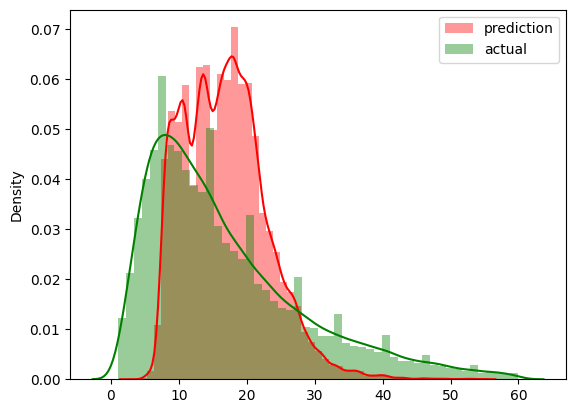

In [36]:
sns.distplot(y_pred, label='prediction', color='r')
sns.distplot(y_train, label='actual', color='g')
plt.legend()

In [37]:
mean_squared_error(y_train, y_pred, squared=False)

9.838799799829435

In [77]:
def read_data(filename):
    df = pd.read_parquet(filename)
    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda x: x.total_seconds() / 60)
    
    ## filter dataframe for minimal duration
    df = df[(df.duration >=1) & (df.duration <=60)]
    
    ## categorical features
    categorical = ['PULocationID','DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    
    return df

In [78]:
df_train = read_data('../../data/green_tripdata_2021-01.parquet')
df_val = read_data('../../data/green_tripdata_2021-02.parquet')

In [79]:
len(df_train), len(df_val)

(73908, 61921)

In [80]:
df_train['PICKUP_DROPOFF'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PICKUP_DROPOFF'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [81]:
categorical = ['PICKUP_DROPOFF']  #['PULocationID','DOLocationID']
numerical = ['trip_distance']
target=['duration']

dv = DictVectorizer()

### train data set
train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)
y_train = df_train[target].values

### Validation set
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_val = df_val[target].values

BASE Model

In [82]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred=lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.75871520559622

In [63]:
### Lasso Model
lsr = Lasso(alpha=0.001)
lsr.fit(X_train, y_train)

y_pred = lsr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

9.233436225720547

In [64]:
### Ridge Model
rr = Ridge(alpha=0.001)
rr.fit(X_train, y_train)

y_pred = rr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.510909603240781

In [65]:
with open('../models/linear_reg.bin','wb') as file:
    pickle.dump((dv, lr), file)

In [66]:
with mlflow.start_run():

    alpha_values = 0.01

    mlflow.set_tag("ml-engineer","Shankar Hadimani")
    mlflow.log_param("train_dataset","../../data/green_tripdata_2021-01.parquet")
    mlflow.log_param("validation_dataset","../../data/green_tripdata_2021-02.parquet")
    mlflow.log_param("alpha",alpha_values)

    ### Lasso Model
    lsr = Lasso(alpha=alpha_values)
    lsr.fit(X_train, y_train)

    y_pred = lsr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse",rmse)

XGBoost with MLFlow

In [83]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [84]:
"""
for XBBoost, train and test datasets should be of particualr datatype.
"""
train = xgb.DMatrix(X_train, label = y_train)
valid = xgb.DMatrix(X_val, label = y_val)

In [73]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "XGBoost")
        mlflow.log_params(params=params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals = [(valid, "validation")],
            early_stopping_rounds = 50
        )

        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss':rmse, 'status':STATUS_OK}

In [74]:
search_space={
    'max_depth':scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate':hp.loguniform('learning_rate', -3,0), #### eg: [exp(3), exp(0)] = [0.05, 1.0]
    'reg_alpha':hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda':hp.loguniform('reg_lambda',-6, -1),
    'min_child_weight':hp.loguniform('min_child_weight',-1, 3),
    'objective':'reg:linear',
    'seed':42, 
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

[15:57:07] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:17.96733                          
[1]	validation-rmse:15.39447                          
[2]	validation-rmse:13.35765                          
[3]	validation-rmse:11.76343                          
[4]	validation-rmse:10.52679                          
[5]	validation-rmse:9.57688                           
[6]	validation-rmse:8.85858                           
[7]	validation-rmse:8.31855                           
[8]	validation-rmse:7.91347                           
[9]	validation-rmse:7.60918                           
[10]	validation-rmse:7.38097                          
[11]	validation-rmse:7.21160                          
[12]	validation-rmse:7.08412                          
[13]	validation-rmse:6.98745                          
[14]	validation-rmse:6.91522                          
[15]	validation-rmse:6.85905                          
[

KeyboardInterrupt: 


Auto Logging in MLFlow


Hyper parameters from previous runs in mlflow UI.

In [86]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

"""
for XBBoost, train and test datasets should be of particualr datatype.
"""
train = xgb.DMatrix(X_train, label = y_train)
valid = xgb.DMatrix(X_val, label = y_val)

with mlflow.start_run():
    params ={
            'learning_rate':	0.10800059175796056,
            'max_depth'	:31,
            'min_child_weight'	:0.8147105846470227,
            'objective'	:'reg:linear',
            'reg_alpha'	:0.36333096092509104,
            'reg_lambda':	0.08133503755271358,
            'seed':	42
            }

    mlflow.xgboost.autolog()
    booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=100,
            evals = [(valid, "validation")],
            early_stopping_rounds = 50
        )
    

2022/12/30 17:29:32 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'c4066b7327404b0cb504b2125f31b9ed', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[17:29:32] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:19.27271


KeyboardInterrupt: 

disable autlog

In [88]:
mlflow.autolog(disable=True)

### Log Metrics into MLFlow

In [90]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

"""
for XBBoost, train and test datasets should be of particualr datatype.
"""
train = xgb.DMatrix(X_train, label = y_train)
valid = xgb.DMatrix(X_val, label = y_val)

with mlflow.start_run():
    best_params ={
                'learning_rate':	0.10800059175796056,
                'max_depth'	:31,
                'min_child_weight'	:0.8147105846470227,
                'objective'	:'reg:linear',
                'reg_alpha'	:0.36333096092509104,
                'reg_lambda':	0.08133503755271358,
                'seed':	42
                }
    mlflow.log_params(best_params)

    booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=100,
            evals = [(valid, "validation")],
            early_stopping_rounds = 50
        )

    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_true=y_val, y_pred=y_pred, squared=False)



    ## log metrics
    mlflow.log_metric('rmse', rmse)

    
    ### Log artifacts
    
    # log preprocessing dictionary vectorizer file as an artifact
    with open('../models/preprocessor.b','wb') as file_out:
        pickle.dump(dv,file_out)
    
    mlflow.log_artifact('../models/preprocessor.b', artifact_path='models_preprocessor')

    ## log model
    mlflow.xgboost.log_model(booster, artifact_path='models_mlflow')


[18:06:58] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:19.27271
[1]	validation-rmse:17.58096
[2]	validation-rmse:16.09460
[3]	validation-rmse:14.79247
[4]	validation-rmse:13.65249
[5]	validation-rmse:12.66157
[6]	validation-rmse:11.79953
[7]	validation-rmse:11.04859
[8]	validation-rmse:10.40265
[9]	validation-rmse:9.84696
[10]	validation-rmse:9.36846
[11]	validation-rmse:8.95829
[12]	validation-rmse:8.60766
[13]	validation-rmse:8.31241
[14]	validation-rmse:8.05979
[15]	validation-rmse:7.84580
[16]	validation-rmse:7.66127
[17]	validation-rmse:7.50494
[18]	validation-rmse:7.37282
[19]	validation-rmse:7.26081
[20]	validation-rmse:7.16471
[21]	validation-rmse:7.08270
[22]	validation-rmse:7.01235
[23]	validation-rmse:6.95280
[24]	validation-rmse:6.90065
[25]	validation-rmse:6.85723
[26]	validation-rmse:6.81811
[27]	validation-rmse:6.78406
[28]	validation-rmse:6.75505
[29]	validation-rmse:6.73118
[30]	validat

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR

mlflow.sklearn.autolog()

for model_class in (RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, LinearSVR):

    with mlflow.start_run():

        mlflow.log_param("train-data-path", "../../data/green_tripdata_2021-01.parquet")
        mlflow.log_param("valid-data-path", "../../data/green_tripdata_2021-02.parquet")
        mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

        mlmodel = model_class()
        mlmodel.fit(X_train, y_train)

        y_pred = mlmodel.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

### USING MLFlow CLIENT

Create experiments in MLFlowClient

In [96]:
from mlflow.client import MlflowClient

tracking_uri_name = "sqlite:///mlflow.db"
client = MlflowClient(tracking_uri=tracking_uri_name)

In [104]:
client.create_experiment("my-cool-experiment")

'2'

search for runs in experiment

In [114]:
from mlflow.entities import ViewType
runs = client.search_runs(
    experiment_ids='1',
    filter_string="metrics.rmse < 6.5",
    run_view_type=ViewType.ACTIVE_ONLY,
    max_results=5,
    order_by=["metrics.rmse ASC"]
)


for run in runs:
    print(f"runid:{run.info.run_id}, rmse:{run.data.metrics['rmse'] }")

runid:229ce5abaca34d95b44058e6f670bc12, rmse:6.369711785980039
runid:389dd0397cd5438190cb19f954386d26, rmse:6.41663871312377
runid:df2d2fc68d1843c2b8414a979905b917, rmse:6.4353280866326505
runid:255e9dc9ef804118a25001fec8ed4bf8, rmse:6.471315025692176
runid:1f867ac67c704d848df3889f373632db, rmse:6.492657182043328


## REGISTER the MODEL

In [ ]:
import mlflow

tracking_uri_name="sqlite:///mlflow.db"
mlflow.set_tracking_uri(tracking_uri_name)

Register the Model

In [115]:
run_id = "1f867ac67c704d848df3889f373632db"
model_uri_name = f"runs/{run_id}/model"#
model_name="nyc-taxi-regressor"
mlflow.register_model(model_uri=model_uri_name, name=model_name)

Successfully registered model 'nyc-taxi-regressor'.
2022/12/30 22:15:20 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: nyc-taxi-regressor, version 1
Created version '1' of model 'nyc-taxi-regressor'.


<ModelVersion: creation_timestamp=1672438520452, current_stage='None', description=None, last_updated_timestamp=1672438520452, name='nyc-taxi-regressor', run_id=None, run_link=None, source='runs/1f867ac67c704d848df3889f373632db/model', status='READY', status_message=None, tags={}, user_id=None, version=1>

In [116]:
print(model_uri_name)

runs/1f867ac67c704d848df3889f373632db/model


### Transition the model into higher stages

In [121]:
### get models versions
model_name="nyc-taxi-regressor"
latest_versions = client.get_latest_versions(name=model_name)

for version in latest_versions:
    print(f"version:{version.version}, stage: {version.current_stage}")

version:1, stage: None


In [127]:
model_version = 1
env_stage = "Staging"
client.transition_model_version_stage(
    name=model_name,
    version=model_version,
    stage=env_stage,
    archive_existing_versions=False
)

<ModelVersion: creation_timestamp=1672438520452, current_stage='Staging', description=None, last_updated_timestamp=1672439929471, name='nyc-taxi-regressor', run_id=None, run_link=None, source='runs/1f867ac67c704d848df3889f373632db/model', status='READY', status_message=None, tags={}, user_id=None, version=1>

Update Model registry

In [128]:
from datetime import datetime

client.update_model_version(
    name=model_name,
    version=model_version,
    description=f"The model version {model_version} is transitioned to {env_stage} at {datetime.today()}"
)

<ModelVersion: creation_timestamp=1672438520452, current_stage='Staging', description='The model version 1 is transitioned to Staging at 2022-12-30 22:39:14.440591', last_updated_timestamp=1672439954443, name='nyc-taxi-regressor', run_id=None, run_link=None, source='runs/1f867ac67c704d848df3889f373632db/model', status='READY', status_message=None, tags={}, user_id=None, version=1>